# Lab Question: Radial Basis Function (RBF) Network for Handwritten Character Recognition

Objective:

Implement a Radial Basis Function (RBF) Network to classify ancient Japanese
characters from the Kuzushiji dataset.

**1.Data Preparation:**

o Load the Kuzushiji dataset from the provided link.

o Preprocess the data by normalizing the pixel values between 0 and 1.

o Split the dataset into training (80%) and testing (20%) sets.

**2.Radial Basis Function (RBF) Network:**

o Implement an RBF network using a Gaussian basis function.

o Define the architecture:

▪ Input layer: 28x28 (784 features for each image).

▪ Hidden layer: RBF units with a Gaussian function.

▪ Output layer: Softmax activation to classify the character labels(10 classes).

**3.Training:**

o Use K-means clustering to determine the centers of the RBF units.

o Implement gradient descent to optimize the network's weights.

o Train the network on the training set with a learning rate of 0.01 for 100
epochs.

**4.Evaluation:**

o Evaluate the model on the test set using accuracy and confusion matrix.

o Visualize the performance evaluation metrics

**5.Analysis:**

o Discuss the strengths and limitations of using an RBF network for this
dataset.

o How does the number of RBF units affect model performance?

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anokas/kuzushiji")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/anokas/kuzushiji/versions/3


In [15]:
import os
# List contents of the directory
print("Contents of the directory:")
for item in os.listdir(path):
    print(item)

Contents of the directory:
k49-test-labels.npz
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte.gz
train-labels-idx1-ubyte.gz
kmnist-train-imgs.npz
kmnist_classmap.csv
train-labels-idx1-ubyte
t10k-labels-idx1-ubyte
k49_classmap.csv
kmnist-train-labels.npz
train-images-idx3-ubyte
kkanji.tar
k49-test-imgs.npz
train-images-idx3-ubyte.gz
k49-train-labels.npz
k49-train-imgs.npz
kmnist-test-labels.npz
kkanji
t10k-images-idx3-ubyte.gz
kmnist-test-imgs.npz


In [16]:
import pandas as pd

csv_file = 'kmnist_classmap.csv'
full_path = os.path.join(path, csv_file)

# Now read the CSV file
df = pd.read_csv(full_path)
print(df.head())

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な


In [17]:
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [18]:
# Define paths to the .npz files
train_images_path = os.path.join(path, 'kmnist-train-imgs.npz')
train_labels_path = os.path.join(path, 'kmnist-train-labels.npz')
test_images_path = os.path.join(path, 'kmnist-test-imgs.npz')
test_labels_path = os.path.join(path, 'kmnist-test-labels.npz')

# Load the .npz files containing the image data and labels
train_images = np.load(train_images_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']
test_images = np.load(test_images_path)['arr_0']
test_labels = np.load(test_labels_path)['arr_0']

# Display the shape of the datasets (optional)
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

# Normalize the pixel values between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Flatten the images from 28x28 to 784 for the RBF network
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Split the dataset into training and validation (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Check the final shapes after splitting (optional)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)
X_train shape: (48000, 784)
y_train shape: (48000,)
X_val shape: (12000, 784)
y_val shape: (12000,)


In [22]:
# Function to compute Gaussian RBF
def rbf(x, centers, sigma):
    x = np.expand_dims(x, axis=0)  # Ensure x is 2-dimensional
    distances = np.linalg.norm(x - centers, axis=1)
    return np.exp(-distances ** 2 / (2 * sigma ** 2))

# Transform the input data using RBFs
def transform_rbf(X, centers, sigma):
    transformed_X = np.zeros((X.shape[0], len(centers)))
    for i in range(X.shape[0]):
        for j in range(len(centers)):
            transformed_X[i, j] = rbf(X[i], centers[j], sigma)
    return transformed_X

# Step 1: K-means clustering to determine centers for the RBF units
n_rbf_units = 100  # Number of RBF units (you can experiment with this number)
kmeans = KMeans(n_clusters=n_rbf_units, random_state=42)
kmeans.fit(X_train)

# Get the RBF centers from K-means and calculate sigma
centers = kmeans.cluster_centers_
sigma = np.mean([np.linalg.norm(centers[i] - centers[j]) for i in range(n_rbf_units) for j in range(i + 1, n_rbf_units)])

# Transform the training and validation data using RBF units
X_train_rbf = transform_rbf(X_train, centers, sigma)
X_val_rbf = transform_rbf(X_val, centers, sigma)

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_val_cat = to_categorical(y_val, num_classes=10)

# Step 2: Build the RBF network architecture
model = Sequential()
model.add(InputLayer(input_shape=(n_rbf_units,)))  # Input shape is equal to the number of RBF units
model.add(Dense(10, activation='softmax'))  # Output layer with 10 classes and Softmax

# Compile the model with Adam optimizer and cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


<ipython-input-22-07834f7de300>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transformed_X[i, j] = rbf(X[i], centers[j], sigma)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [23]:
# Train the model
history = model.fit(X_train_rbf, y_train_cat, epochs=100, batch_size=32, validation_data=(X_val_rbf, y_val_cat))


Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4978 - loss: 1.6188 - val_accuracy: 0.6785 - val_loss: 1.0575
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6928 - loss: 1.0035 - val_accuracy: 0.7107 - val_loss: 0.9217
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7298 - loss: 0.8843 - val_accuracy: 0.7390 - val_loss: 0.8449
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7458 - loss: 0.8151 - val_accuracy: 0.7604 - val_loss: 0.7786
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7609 - loss: 0.7761 - val_accuracy: 0.7623 - val_loss: 0.7661
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7681 - loss: 0.7427 - val_accuracy: 0.7682 - val_loss: 0.7386
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7742 - loss: 0.7153 - val_accuracy: 0.7844 - val_loss: 0.7078
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7766 - loss: 0

<ipython-input-22-07834f7de300>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transformed_X[i, j] = rbf(X[i], centers[j], sigma)


Test Accuracy: 69.01%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy Score: 69.01%
Confusion Matrix:
 [[844   3   6   7  27  54   3  23  27   6]
 [ 10 643 116  12  45  17 113   2  14  28]
 [ 12  35 768  30  20  20  62   9  33  11]
 [  6  26 146 724  19  30  16   7  24   2]
 [110  30  79  15 666  14  32   7  14  33]
 [ 11  19 154  16  22 726  29   2  19   2]
 [  4  12 174   6  29   8 756   7   1   3]
 [ 31  14  39  19 189  10 100 460  89  49]
 [ 22  42  83  53   8  35  52   2 697   6]
 [ 22  44 129   3  74  10  48  19  34 617]]


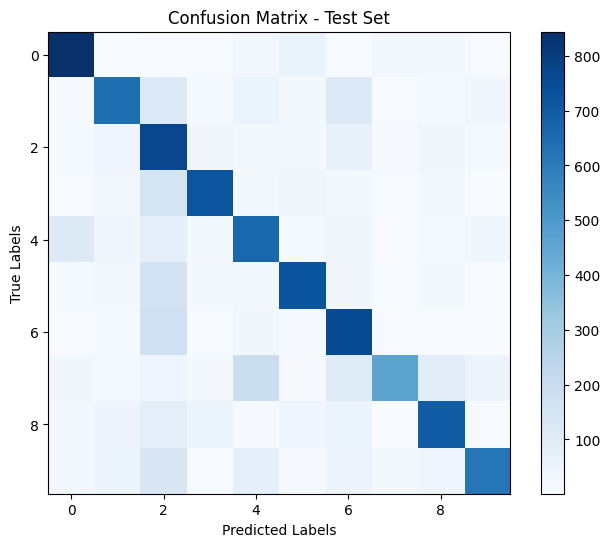

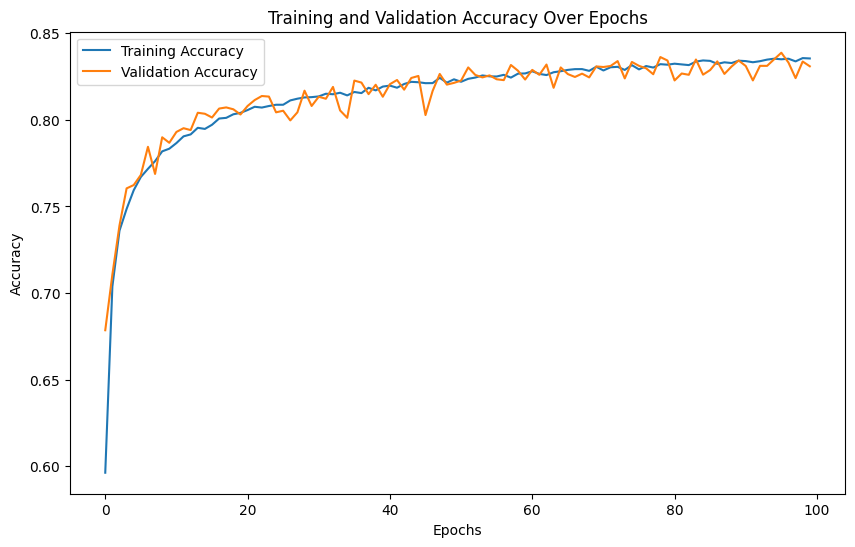

In [24]:
# Evaluation on the test set

# Transform the test set using RBF units
X_test_rbf = transform_rbf(test_images, centers, sigma)

# One-hot encode the test labels
y_test_cat = to_categorical(test_labels, num_classes=10)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rbf, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on the test set
y_test_pred = np.argmax(model.predict(X_test_rbf), axis=1)

# Calculate accuracy score
test_accuracy_score = accuracy_score(test_labels, y_test_pred)
print(f"Test Accuracy Score: {test_accuracy_score * 100:.2f}%")

# Generate the confusion matrix
test_conf_matrix = confusion_matrix(test_labels, y_test_pred)
print("Confusion Matrix:\n", test_conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(test_conf_matrix, cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
plt.show()

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()